# Leaf Classification CNN

## Libraries

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import cv2
import sys, os, shutil, glob, random, csv, time
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.model_selection import train_test_split



## Data IO / Image Preprocessing

In [2]:
#IO functions

def load_image(file_path):
    return cv2.imread(file_path)

def create_directory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        pass

def extract_names(label_file):
    names = list()
    with open('label_legend.csv', newline='') as f:
        reader = csv.reader(f)
        legend = dict(reader)
    for img in label_file:
        names.append(legend[str(img)])
    return names

def process_data(source_path, dest_path, desired_size, transform=False, edges=False):
    create_directory(dest_path)
    names = []
    legend = dict()
    j=0
    species_folders = os.listdir(source_path)
    for i, folder in enumerate(species_folders):
        if folder[0] == '.':
            continue
        id = str(i).rjust(2, '0')
        legend[folder] = id
        folder_path = os.listdir(os.path.join(source_path, folder))
        num_folders = len(folder_path)
        clear_output(wait=True)
        print("Folder:", i, "/100", flush=True)
        for jpgfile in folder_path:
            #resize
            img = load_image(os.path.join(source_path, folder, jpgfile))
            old_size = img.shape[:2]
            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            img = cv2.resize(img, (new_size[1], new_size[0]))
            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            color = [0, 0, 0]
            new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
                value=color)
    
            #rename
            new_name = id + str(j)
            j += 1
            fname = os.path.join(dest_path, new_name)
            if edges:
                new_im = cv2.Canny(new_im, 100, 200)
            if transform:
                # 2x mirror
                img_flip_vert = np.flip(new_im, axis=0)
                filename = os.path.join(fname + '_vert.jpg')
                cv2.imwrite(filename, img_flip_vert)

                img_flip_horiz = np.flip(new_im, axis=1)
                filename = os.path.join(fname + '_horiz.jpg')
                cv2.imwrite(filename, img_flip_horiz)

                # rotate 3 times and save
                for i in range(1, 4):
                    img_flip_vert = cv2.rotate(img_flip_vert, cv2.ROTATE_90_CLOCKWISE)
                    filename = os.path.join(fname + '_' + str(i*90) + '_vert.jpg')
                    cv2.imwrite(filename, img_flip_vert)

                    img_flip_horiz = cv2.rotate(img_flip_horiz, cv2.ROTATE_90_CLOCKWISE)
                    filename = os.path.join(fname + '_' + str(i*90) + '_horiz.jpg')
                    cv2.imwrite(filename, img_flip_horiz)
            cv2.imwrite(os.path.join(fname+'.jpg'), new_im)
    csv_name = 'label_legend.csv'
    with open(csv_name, 'w') as csvfile:
        for key in legend.keys():
            csvfile.write("%d,%s\n"%(int(legend[key]), key))
            
def blackandwhite(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return img / 255.0
            

In [3]:
#copy dataset into dest_name folder and create a 'label legend'

dest_name = 'ninety-six'
desired_size = 96

#root_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'datasets')
root_path = os.path.join(os.getcwd(), 'datasets')
dest_path = os.path.join(root_path, dest_name)
process_data(os.path.join(root_path, '100 leaves plant species', 'data'), dest_path, desired_size, transform=True, edges=True)

Folder: 99 /100


In [4]:
#Split processed dataset into training and validation

test_perc = .25
random_seed = 101
data_path = dest_path
image_files = os.listdir(dest_path)
data = [load_image(os.path.join(data_path, file)) for file in image_files]
data = [blackandwhite(img) for img in data]
labels = [int(file[:2]) for file in image_files]
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=test_perc, random_state=random_seed)
test_label_name = extract_names(test_labels)
print("training labels: ", train_labels[:10])
print("testing labels: ", test_labels[:10])
print("testing names:", test_label_name[:10])

training labels:  [64, 86, 21, 83, 97, 57, 11, 82, 16, 48]
testing labels:  [76, 12, 16, 70, 41, 87, 90, 55, 82, 83]
testing names: ['Quercus_Pubescens', 'Alnus_Maximowiczii', 'Arundinaria_Simonii', 'Quercus_Kewensis', 'Magnolia_Salicifolia', 'Quercus_x_Hispanica', 'Salix_Fragilis', 'Quercus_Canariensis', 'Quercus_Suber', 'Quercus_Texana']


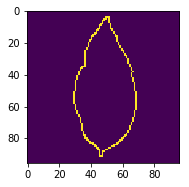

In [5]:
preview_index = random.randint(0, len(train_images)-1)
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])

In [6]:
train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(type(train_images[0]), type(train_labels[0]))
print(train_labels[:15])
print(train_images.shape, train_labels.shape)
print(train_images[0].shape)

<class 'numpy.ndarray'> <class 'numpy.int32'>
[64 86 21 83 97 57 11 82 16 48 31 23 25 73  7]
(10800, 96, 96, 1) (10800,)
(96, 96, 1)


## CONVOLUTIONAL NET

In [7]:
layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    #tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    #tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=100, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=15, batch_size=50)
loss, accuracy = model.Evaluate()
model.save_weights("model.tf")

Train on 10800 samples
Epoch 1/15
10800/10800 [==============================] - 24s 2ms/sample - loss: 2.5978 - sparse_categorical_accuracy: 0.3242
Epoch 2/15
10800/10800 [==============================] - 22s 2ms/sample - loss: 1.1678 - sparse_categorical_accuracy: 0.6488
Epoch 3/15
10800/10800 [==============================] - 22s 2ms/sample - loss: 0.6554 - sparse_categorical_accuracy: 0.7963
Epoch 4/15
10800/10800 [==============================] - 24s 2ms/sample - loss: 0.4130 - sparse_categorical_accuracy: 0.8681
Epoch 5/15
10800/10800 [==============================] - 24s 2ms/sample - loss: 0.2577 - sparse_categorical_accuracy: 0.9166
Epoch 6/15
10800/10800 [==============================] - 21s 2ms/sample - loss: 0.1886 - sparse_categorical_accuracy: 0.9395
Epoch 7/15
10800/10800 [==============================] - 22s 2ms/sample - loss: 0.1262 - sparse_categorical_accuracy: 0.9604
Epoch 8/15
10800/10800 [==============================] - 23s 2ms/sample - loss: 0.1227 - spars

In [8]:
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.tf")
eval_predictions = eval_model.predict(np.expand_dims(test_images, axis=-1))
cols = 4
rows = np.ceil(len(test_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 4)
predicted_labels = np.argmax(eval_predictions, axis=1)
predicted_names = extract_names(predicted_labels)
predicted_correct = [1 if predicted_labels[i] ==  test_labels[i] else 0 for i in range(len(test_labels))  ]
accuracy = np.sum(predicted_correct) / len(test_labels)
print("Test Accuracy = ", accuracy)
for i in range(15):
    plt.subplot(rows, cols, i+1)
    plt.imshow(test_images[i], cmap="gray")
    title = predicted_names[i][10:] + " / " + test_label_name[i][10:]
    plt.title(title)
    plt.axis('off')

Test Accuracy =  0.9125
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000029ACE604C80> (for post_execute):


ValueError: Image size of 1152x259200 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1152x259200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1152x259200 with 15 Axes>